### **Project: Bank Customer Segmentation & Targeted Marketing**

### Data Cleaning & Preprocessing

### Objective:
- Handle missing or inconsistent values
- Fix data types and formatting issues
- Detect and treat outliers
- Address skewness in key features
- Normalize or scale numerical variables
- Prepare a clean and well-structured dataset for modeling


#### Importing necessary libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings 
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

#### importing the raw dataset

In [7]:
df_raw = pd.read_csv('../data//raw/Bank_Customers_Dataset.csv')

## Handling Null values

Checked for missing values in each column to assess data quality.

In [8]:
df_raw.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Investigate Missing CREDIT_LIMIT

#### Clean & Drop Invalid CREDIT_LIMIT
Replaced invalid entries with NaN and dropped rows with missing CREDIT_LIMIT.

In [9]:
df_raw['CREDIT_LIMIT'] = df_raw['CREDIT_LIMIT'].replace(['NA','null','',' '], np.nan)
df_raw = df_raw.dropna(subset=['CREDIT_LIMIT'])

#### Fill Missing MINIMUM_PAYMENTS
Imputed missing values using median of PAYMENTS.

In [10]:
df_raw['MINIMUM_PAYMENTS'] = df_raw['MINIMUM_PAYMENTS'].fillna(df_raw['PAYMENTS'].median())
df_raw['MINIMUM_PAYMENTS'].isnull().sum()

0

#### Final Null Check
Confirmed all missing values were handled.

In [11]:
df_raw.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

## Feature Engineering
Feature Engineering Ideas Aligned with Marketing Strategy

#### Total Purchases
Combines one-off and installment purchases into one feature to capture overall purchasing behavior.



In [12]:
df_raw['TOTAL_PURCHASES'] = df_raw['ONEOFF_PURCHASES'] + df_raw['INSTALLMENTS_PURCHASES']

#### Purchase Type Ratio
Shows the proportion of one-off to total purchases (useful for understanding purchase preference).

In [13]:
df_raw['PURCHASE_TYPE_RATIO'] = df_raw['ONEOFF_PURCHASES'] / (df_raw['TOTAL_PURCHASES'] + 1e-6)

#### Credit Utilization Rate
How much of the credit limit a customer typically uses.

In [14]:
df_raw['CREDIT_UTILIZATION'] = df_raw['BALANCE'] / (df_raw['CREDIT_LIMIT'] + 1e-6)

#### Payment to Balance Ratio
Gives insight into whether the customer is paying off their balance or not.

In [15]:
df_raw['PAYMENT_RATIO'] = df_raw['PAYMENTS'] / (df_raw['BALANCE'] + 1e-6)

#### Revolver Indicator
Creates a binary indicator (or scaled version) showing if a customer usually pays in full.

In [16]:
df_raw['REVOLVER_FLAG'] = (df_raw['PRC_FULL_PAYMENT'] > 0.5).astype(int)

#### Cash Usage Ratio
Tells whether a customer relies more on cash advances or purchases.

In [17]:
df_raw['CASH_USAGE_RATIO'] = df_raw['CASH_ADVANCE'] / (df_raw['TOTAL_PURCHASES'] + 1e-6)

#### Activity Index
This aggregates different frequency metrics into one engagement score.

In [18]:
df_raw['ACTIVITY_INDEX'] = (
    df_raw['BALANCE_FREQUENCY'] + 
    df_raw['PURCHASES_TRX'] +
    df_raw['ONEOFF_PURCHASES_FREQUENCY'] +
    df_raw['CASH_ADVANCE_FREQUENCY']
)

Confirm Feature Engineering

In [19]:
df_raw.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'TOTAL_PURCHASES',
       'PURCHASE_TYPE_RATIO', 'CREDIT_UTILIZATION', 'PAYMENT_RATIO',
       'REVOLVER_FLAG', 'CASH_USAGE_RATIO', 'ACTIVITY_INDEX'],
      dtype='object')

### Outlier Detection (Boxplots)
Plotted boxplots for engineered features to visually inspect outliers.
#### Features checked:
- `ACTIVITY_INDEX`, `CASH_USAGE_RATIO`, `REVOLVER_FLAG`
- `PAYMENT_RATIO`, `CREDIT_UTILIZATION`, `PURCHASE_TYPE_RATIO`

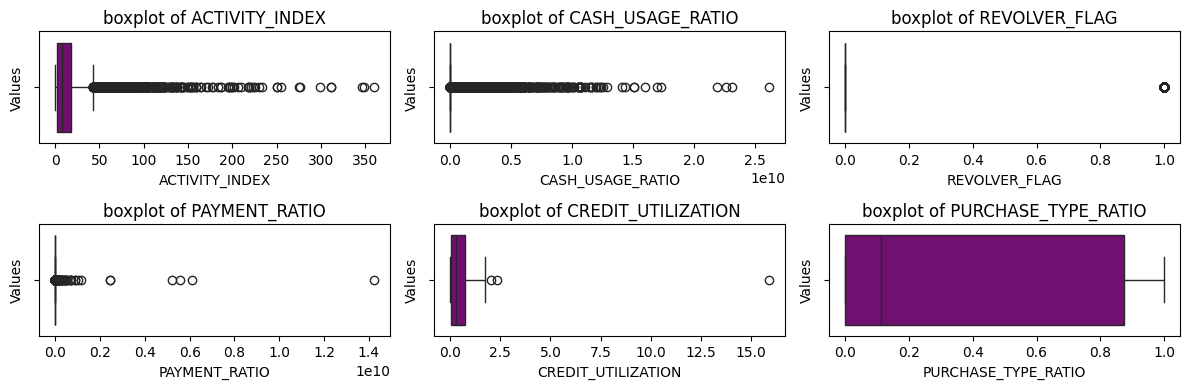

In [ ]:
import math 
feature_to_check = ['ACTIVITY_INDEX', 'CASH_USAGE_RATIO' , 'REVOLVER_FLAG', 'PAYMENT_RATIO', 'CREDIT_UTILIZATION', 'PURCHASE_TYPE_RATIO']
plt.Figure(figsize=(16,4))
fig , axes = plt.subplots(math.ceil(len(feature_to_check) / 3) , 3 , figsize=(12,4))
axes = axes.flatten()

for i, col in enumerate(feature_to_check):
    sns.boxplot(df_raw[col] , color='purple' , ax=axes[i] , orient='h')
    axes[i].set_title(f'boxplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Values')

for j in range(i+1 , len(feature_to_check)):
    axes[j].set_visibility(False)

plt.tight_layout()
plt.show()

### Outlier Capping Function
Defined a function to cap outliers using the IQR method.

Values above `Q3 + 1.5*IQR` are capped to upper bound

Values below `Q1 - 1.5*IQR` are capped to lower bound

In [21]:
def cap_outliers(df, features):
    summary = []
    for ft in features:
        Q1 = df[ft].quantile(0.25)
        Q3 = df[ft].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        lower_count = (df[ft] < lower_bound).sum()
        upper_count = (df[ft] > upper_bound).sum()

        df[ft] = np.where(df[ft] > upper_bound, upper_bound, np.where(df[ft] < lower_bound, lower_bound, df[ft]))
        
        summary.append({ 'Feature': ft, 'Lower Capped': lower_count, 'Upper Capped': upper_count, 'Total Capped': lower_count + upper_count})

    summary_df = pd.DataFrame(summary).sort_values(by='Total Capped', ascending=False).reset_index(drop=True)
    return df, summary_df

outlier_features = [
    'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
    'INSTALLMENTS_PURCHASES', 'ONEOFF_PURCHASES_FREQUENCY', 'CASH_ADVANCE',
    'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT',
    'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'ACTIVITY_INDEX', 'CASH_USAGE_RATIO' , 'PAYMENT_RATIO', 'CREDIT_UTILIZATION'
]

### Apply Outlier Capping
Applied capping to all relevant numerical features.

In [22]:
df_cleaned , outlier_summary = cap_outliers(df_raw, outlier_features)
outlier_summary

,Feature,Lower Capped,Upper Capped,Total Capped
0,CASH_USAGE_RATIO,0,2117,2117
1,BALANCE_FREQUENCY,1492,0,1492
2,PRC_FULL_PAYMENT,0,1474,1474
3,CASH_ADVANCE,0,1030,1030
4,ONEOFF_PURCHASES,0,1013,1013
5,INSTALLMENTS_PURCHASES,0,867,867
6,PURCHASES,0,808,808
7,PAYMENT_RATIO,0,808,808
8,PAYMENTS,0,808,808
9,CASH_ADVANCE_TRX,0,804,804


## Feature Scaling for Clustering

###  Step 1: Silhouette Evaluation Function

Defined a helper to compute and plot Silhouette Scores for \(k=2\) to \(10\).  
This function standardizes the evaluation across different scalers.

In [19]:
def evaluate_scaling_method(df):
     silhouette_scores = []
     for i in range(2, 11):
         kmeans = KMeans(n_clusters=i, random_state=42)
         clusters = kmeans.fit_predict(df)
         silhouette_scores.append(silhouette_score(df, clusters))

     plt.plot(range(2, 11), silhouette_scores, marker='o')
     plt.title('Silhouette Scores for Different Numbers of Clusters')
     plt.xlabel('Number of Clusters')
     plt.ylabel('Silhouette Score')
     plt.show()

### Step 2: Drop Identifier Column

Removed the `CUST_ID` column, which is not needed for clustering.

In [20]:
columns_to_drop = ['CUST_ID']  # Dropping unnecessary columns
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

### Step 3: Scaling Function Definition

Created a flexible function to scale selected features with Robust, MinMax, or Standard scaler,  
while preserving the rest of the DataFrame.

In [23]:
def scale_selected_features(df, features, scaler_type='robust'):
    if scaler_type == 'robust':
        scaler = RobustScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Choose 'robust', 'minmax', or 'standard'")

    scaled_part = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)
    df_rest = df.drop(columns=features)
    df_scaled_final = pd.concat([scaled_part, df_rest], axis=1)
    return df_scaled_final

feature_to_scale = ['BALANCE','PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES','CASH_ADVANCE','PAYMENTS',
                'MINIMUM_PAYMENTS','TOTAL_PURCHASES','CASH_USAGE_RATIO','PAYMENT_RATIO','CASH_ADVANCE_TRX','PURCHASES_TRX', 'CREDIT_LIMIT', 
                 'ACTIVITY_INDEX', 'BALANCE_FREQUENCY' 
]


### Step 4: Robust Scaling Evaluation

Evaluating Robust Scaling


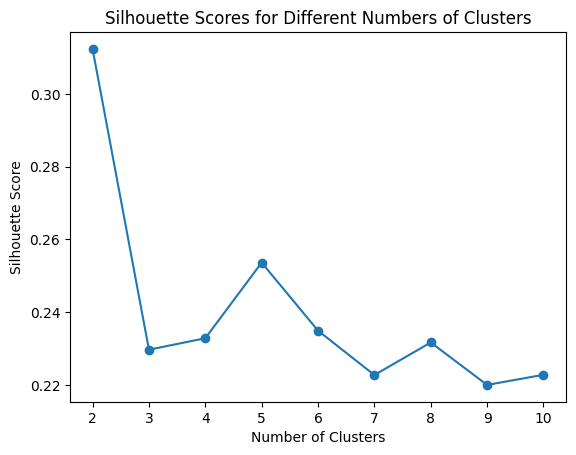

In [22]:
df_scaled = scale_selected_features(df_cleaned, feature_to_scale, scaler_type='robust')
print("Evaluating Robust Scaling")
evaluate_scaling_method(df_scaled)

Applied **RobustScaler** and plotted Silhouette Scores.  
**Result:** Peak Silhouette ~0.34 at \(k=2\), dropping for higher \(k\).  
Indicates limited separation when using robust scaling.

### Step 5: Min–Max Scaling Evaluation

Evaluating Minmax Scaling


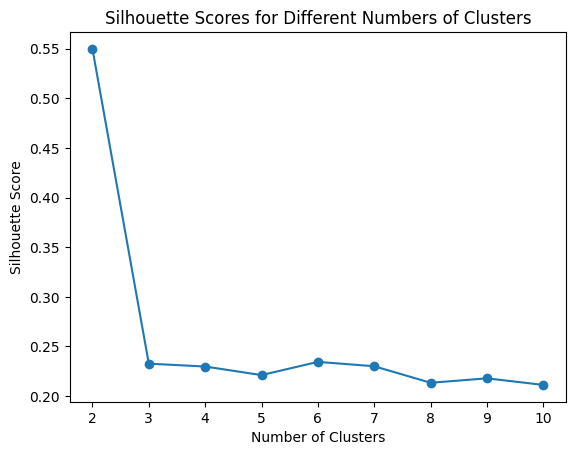

In [23]:
df_scaled = scale_selected_features(df_cleaned, feature_to_scale, scaler_type='minmax')
print("Evaluating Minmax Scaling")
evaluate_scaling_method(df_scaled)

Applied **MinMaxScaler** and plotted Silhouette Scores.  
**Result:** Peak Silhouette ~0.55 at \(k=2\), significantly higher than other scalers.  
Suggests Min–Max scaling yields the most compact, well-separated clusters for \(k=2\).

### Step 6: Standard Scaling Evaluation

Evaluating standard Scaling


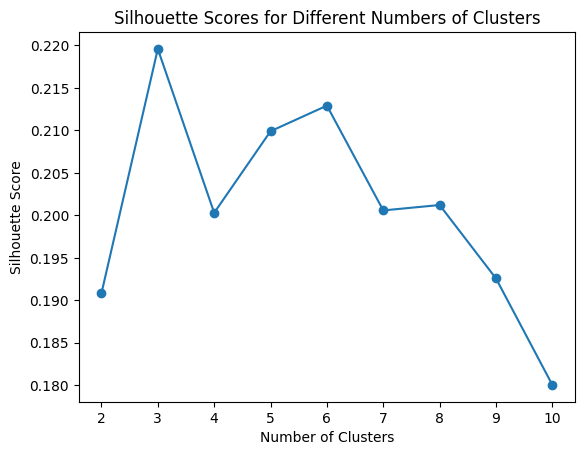

In [24]:
df_scaled = scale_selected_features(df_cleaned, feature_to_scale, scaler_type='standard')
print("Evaluating standard Scaling")
evaluate_scaling_method(df_scaled)

Applied **StandardScaler** and plotted Silhouette Scores.  
**Result:** Peak Silhouette ~0.22 at \(k=2\), the lowest among tested scalers.  
Indicates standard scaling is not optimal for this clustering task.

### Step 7: Raw Data (No Scaling) Evaluation

Evaluating Without Scaling Only Cleaned Data


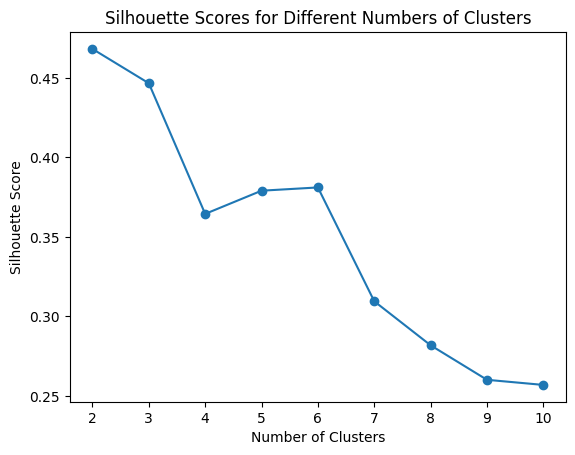

In [25]:
print("Evaluating Without Scaling Only Cleaned Data")
evaluate_scaling_method(df_cleaned)

Evaluated clustering on the **unscaled** cleaned data.  
**Result:** Silhouette ~0.47 at \(k=2\) and ~0.45 at \(k=3\).  
This allows meaningful segmentation beyond two clusters, which is valuable for marketing.

### Step 8: Export Final Dataset

Saved the cleaned (but unscaled) data for clustering.

In [26]:
df_cleaned.to_csv('../data/processed/final_dataset_for_clustering.csv', index=False)

###  Step 9: Log Transformation

Applied a log1p transform to reduce skewness on key features.  
Stored results in `df_log`.

In [27]:
log_features = ['BALANCE','PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES','CASH_ADVANCE','PAYMENTS',
                'MINIMUM_PAYMENTS','TOTAL_PURCHASES','CASH_USAGE_RATIO','PAYMENT_RATIO','CASH_ADVANCE_TRX','PURCHASES_TRX', 'CREDIT_LIMIT', 
                 'ACTIVITY_INDEX', 'BALANCE_FREQUENCY' , 
]
df_log = df_cleaned[log_features].apply(np.log1p)

### Step 10: Log-Scaled Data Evaluation

Ran Silhouette analysis on the log-transformed features.  
**Result:** Poor performance across all \(k\) (all scores < 0.30), so log scaling was not beneficial for clustering.

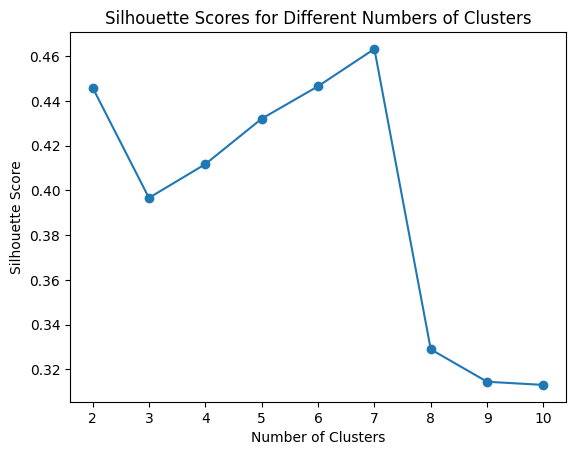

In [28]:
evaluate_scaling_method(df_log)

##  Final Clustering Decision

After extensive testing—including scaling, log‐transform, and raw data—our clean, unscaled dataset with **3 clusters** provides the best balance of performance and interpretability.

### Summary of Key Silhouette Scores

| Approach                   | k  | Silhouette Score |
|----------------------------|----|------------------|
| Cleaned (no scaling)       | 2  | 0.47             |
| Cleaned (no scaling)       | 3  | **0.44**         |
| Min–Max Scaled             | 2  | 0.55             |
| Robust Scaled              | 2  | 0.35             |
| Standard Scaled            | 2  | 0.22             |
| Log‑Transformed (no scale) | 2  | 0.31             |

---

###  Why “Cleaned (No Scaling) + 3 Clusters”?

- **High Cohesion & Separation:** k=3 retains a strong silhouette (~0.44) only slightly below the k=2 peak, while allowing more granularity.  
- **Preserves Natural Patterns:** No scaling/log steps means original customer behaviors are intact—essential for actionable marketing segments.  
- **Actionable Segments:** Three groups strike the right balance between simplicity (easy to explain) and depth (enough segments for targeted campaigns).

---

This **Cleaned + k=3** configuration will be the basis for:

1. **Cluster Profiling** (defining personas)  
2. **Insight Generation** (behavioral analysis)  
3. **Marketing Strategy Recommendations** (tailored campaigns)
